In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle
import glob
import traceback

from scipy import stats as sc_stats
from scipy.special import gamma,loggamma
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2023-05-17 16:04:33.133379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import sys
import os
from os.path import dirname
sys.path.append(dirname("../../"))

In [4]:
from src.edl import dense_layers,dense_loss
from src.weibull_edl import loss_and_layers
from src.exp_utils import lgd_data

In [5]:
%load_ext autoreload
%autoreload 2

### Read the LGD dataset

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_3934/642432279.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean1["recovery_rate_ad"] = np.where(df_clean1["recovery_rate"]<=1.2,df_clean1["recovery_rate"],1.2)


(1.2450120227851276, -0.13070932725535367, 11.690199379997253)


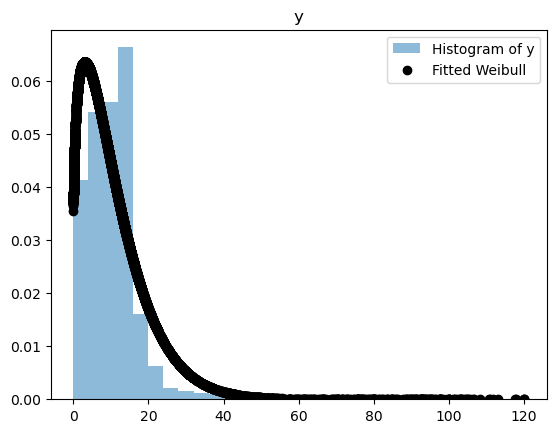

In [6]:
df_clean = pd.read_csv("../../data/data_preprocessed_v0.csv",index_col=0)

# Select columns with 'float64' dtype  
float64_cols = list(df_clean.select_dtypes(include='float64'))

# The same code again calling the columns
df_clean[float64_cols] = df_clean[float64_cols].astype('float32')
df_clean["ccf_ad"] = (1.0-df_clean["CCF"])*100
df_clean1 = df_clean[df_clean.recovery_rate>0.0]
df_clean1["recovery_rate_ad"] = np.where(df_clean1["recovery_rate"]<=1.2,df_clean1["recovery_rate"],1.2)
# df_clean.head()

y_cols = ["recovery_rate","CCF"]

X = df_clean1.drop(columns=y_cols + list(df_clean1.columns)[35:39])
y = df_clean1["recovery_rate_ad"] * 100.0

rv = sc_stats.weibull_min.fit(y)
print (rv)
plt.hist(y,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y, sc_stats.weibull_min.pdf(y,*rv),label="Fitted Weibull",color="black")
plt.title("y")
plt.legend()

In [7]:
y=y-(-0.13071235094229539)
print(X.shape,y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

(23300, 45) (23300,)


((18640, 45), (4660, 45), (18640,), (4660,))

Fitted k =1.246204234699603


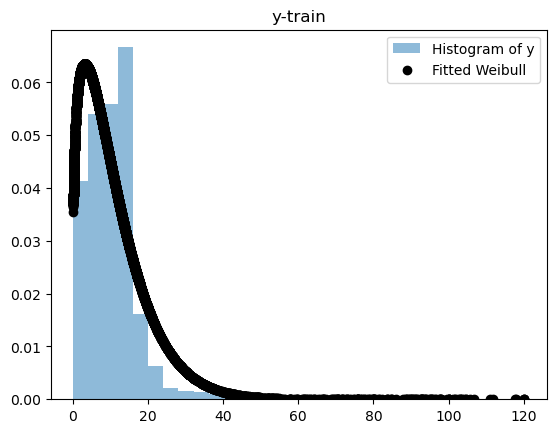

In [8]:
#b.get k from train data
rv = sc_stats.weibull_min.fit(y_train)
k=float(rv[0])
print (f"Fitted k ={k}")

plt.hist(y_train,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y_train, sc_stats.weibull_min.pdf(y_train,*rv),label="Fitted Weibull",color="black")
plt.title("y-train")
plt.legend()

### Experiments

In [9]:
results_trial={}
i = 0
while i <5:
    try:
        print(f"fitting benchmark {i}")
        #run benchmark model
        mu_i, var_i, y_pred_train_i, y_pred_test_i,\
        benchmark_model_i, hist_i = lgd_data.results_benchmark_model(0.043,x_train,y_train,x_test,0)
        a,b = lgd_data.metrics_benchmark(y_train,y_pred_train_i)
        results_trial[(i,"benchmark","train")] = {
                    "mse":a, "nll":b}
        c,d = lgd_data.metrics_benchmark(y_test,y_pred_test_i)
    #         print (f"MSE train={a:.5f}, test = {c:.5f}")
        results_trial[(i,"benchmark","test")] = {
                    "mse":c, "nll":d}
        print (f"MSE train={a:.5f}, test = {c:.5f}")
        print(f"fitting proposed {i}")
        #run proposed model
        mu_prop_i, var_prop_i, y_pred_train_prop_i,\
        y_pred_test_prop_i, proposed_model_i, hist_prop_i = lgd_data.results_weibull_model(0.5,x_train,y_train,x_test,k,0)
        a1,b1 = lgd_data.metrics_proposed(y_train,y_pred_train_prop_i,k)
        results_trial[(i,"proposed","train")] = {
                "mse":a1, "nll":b1}
        c1,d1 = lgd_data.metrics_proposed(y_test,y_pred_test_prop_i,k)
        results_trial[(i,"proposed","test")] = {
                "mse":c1, "nll":d1}
        print (f"MSE train={a1:.5f}, test = {c1:.5f}")
        i+=1
    except:
        print (f"Error for i={i}")
        traceback.print_exc()
        continue

fitting benchmark 0


2023-05-17 16:04:41.487313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


146/146 [==============================] - 0s 2ms/step
MSE train=84.23602, test = 84.14709
fitting proposed 0


/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


146/146 [==============================] - 0s 2ms/step
MSE train=32.66350, test = 33.53005
fitting benchmark 1
146/146 [==============================] - 0s 2ms/step
MSE train=84.61977, test = 84.80188
fitting proposed 1


/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


146/146 [==============================] - 0s 2ms/step
MSE train=43.56094, test = 44.12186
fitting benchmark 2
146/146 [==============================] - 0s 2ms/step
MSE train=83.81411, test = 83.73596
fitting proposed 2


/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


146/146 [==============================] - 0s 2ms/step
Error for i=2
fitting benchmark 2


Traceback (most recent call last):
  File "/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_3934/440964472.py", line 21, in <module>
    a1,b1 = lgd_data.metrics_proposed(y_train,y_pred_train_prop_i,k)
  File "/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py", line 30, in metrics_proposed
    mse = mean_squared_error(y_true, mu)
  File "/Users/ashish1610dhiman/opt/anaconda3/envs/iuq_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/Users/ashish1610dhiman/opt/anaconda3/envs/iuq_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/Users/ashish1610dhiman/opt/anaconda3/envs/iuq_project/lib/python3.9/site-packages/sklearn/utils/validation.py", line 921, in check_array
    _assert_a

146/146 [==============================] - 0s 2ms/step
MSE train=84.31469, test = 84.38790
fitting proposed 2


/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


146/146 [==============================] - 0s 2ms/step
MSE train=41.89696, test = 42.54202
fitting benchmark 3
146/146 [==============================] - 0s 2ms/step
MSE train=84.11184, test = 83.99479
fitting proposed 3


/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


146/146 [==============================] - 0s 2ms/step
MSE train=41.51511, test = 41.79720
fitting benchmark 4
146/146 [==============================] - 0s 2ms/step
MSE train=84.24113, test = 84.22983
fitting proposed 4


/Users/ashish1610dhiman/data_projects/iuq_project/notebooks/neurips_experiments/../../src/exp_utils/lgd_data.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


146/146 [==============================] - 0s 2ms/step
MSE train=1557.84021, test = 1560.03503


In [12]:
result_trial = pd.DataFrame.from_dict(results_trial,orient="index").reset_index()
result_trial = result_trial.rename(columns={"level_0":"trial",\
                                     "level_1":"model_type","level_2":"data_type"})

In [15]:
result_trial[result_trial["trial"]<=3]

,trial,model_type,data_type,mse,nll
0,0,benchmark,train,84.236015,2.758631
1,0,benchmark,test,84.147095,2.746076
2,0,proposed,train,32.663502,2.348293
3,0,proposed,test,33.530048,2.346795
4,1,benchmark,train,84.619774,2.765545
5,1,benchmark,test,84.801880,2.754825
6,1,proposed,train,43.560936,2.303972
7,1,proposed,test,44.121861,2.301469
8,2,benchmark,train,84.314690,2.762047
9,2,benchmark,test,84.387901,2.752372


In [18]:
result_trial[result_trial["trial"]<=3].pivot_table(index="data_type",columns=["model_type"],\
                                                  aggfunc=[np.mean,np.std],\
                                                  values=["mse","nll"])

mean                                      std             
                  mse                  nll                 mse             
model_type  benchmark   proposed benchmark  proposed benchmark  proposed   
data_type                                                                  
test        84.332916  40.497780  2.756653  2.311492  0.352046  4.745195  \
train       84.320580  39.909126  2.766196  2.314237  0.216237  4.911397   

                                
                 nll            
model_type benchmark  proposed  
data_type                       
test        0.011720  0.023573  
train       0.008714  0.022736